In [13]:
import pyccl as ccl
print(f"I am using pyccl version {ccl.__version__}")
import numpy as np
from scripts.data_vectors import DataVectors
from scripts.presets import Presets
import scripts.plotting as p
from scripts.data_vector_metrics import DataVectorMetrics
from IPython.display import display, Markdown

I am using pyccl version 2.8.0


In [2]:
redshift_max = 3.5
redshift_resolution_1 = 300  # this is the first resolution of redshifts
redshift_resolution_2 = 5000  # this is the second resolution of redshifts
forecast_year = "1"
# Please note that the redshift resolution is the number of redshifts between 0 and redshift_max.
# Additionally, a lot of parametric sweeping is already coded into helper functions 
# so we will not need to worry about that for now.

# We will also investigate ell binning but for this particular exercise,
# we will keep the ell binning at default values.
#ell_min = 20
#ell_max = 2000
#n_ell = 50

# We now initialize the class by only passing the redshift information.
presets1 = Presets(redshift_max=redshift_max,
                  redshift_resolution=redshift_resolution_1,
                  forecast_year=forecast_year)
presets2 = Presets(redshift_max=redshift_max,
                    redshift_resolution=redshift_resolution_2,
                    forecast_year=forecast_year)

# We can now access the redshifts and ell values
redshift1 = presets1.redshift_range
redshift2 = presets2.redshift_range
ells1 = presets1.ells
ells2 = presets2.ells

# Now we initialize the DataVectors class with the corresponding presets
dv1 = DataVectors(presets1)
dv2 = DataVectors(presets2)

# and construct our angular power spectra:
# cosmic shear
shear_cls_1 = dv1.cosmic_shear_cls()
shear_cls_2 = dv2.cosmic_shear_cls()
# galaxy clustering
clu_cls_1 = dv1.galaxy_clustering_cls()
clu_cls_2 = dv2.galaxy_clustering_cls()
# galaxy-galaxy lensing
ggl_cls_1 = dv1.galaxy_galaxy_lensing_cls()
ggl_cls_2 = dv2.galaxy_galaxy_lensing_cls()


Data saved to data_output/angular_power_spectra/cosmic_shear_correlations_y1.npy
Data saved to data_output/angular_power_spectra/cosmic_shear_cls_y1_zmax3.5_zres300_ccl_v2.8.0.npy
Data saved to data_output/angular_power_spectra/cosmic_shear_correlations_y1.npy
Data saved to data_output/angular_power_spectra/cosmic_shear_cls_y1_zmax3.5_zres5000_ccl_v2.8.0.npy
Data saved to data_output/angular_power_spectra/galaxy_clustering_correlations_y1.npy
Data saved to data_output/angular_power_spectra/galaxy_clustering_cls_y1_zmax3.5_zres300_ccl_v2.8.0.npy
Data saved to data_output/angular_power_spectra/galaxy_clustering_correlations_y1.npy
Data saved to data_output/angular_power_spectra/galaxy_clustering_cls_y1_zmax3.5_zres5000_ccl_v2.8.0.npy
Data saved to data_output/angular_power_spectra/galaxy_galaxy_lensing_correlations_y1.npy
Data saved to data_output/angular_power_spectra/galaxy_galaxy_lensing_cls_y1_zmax3.5_zres300_ccl_v2.8.0.npy
Data saved to data_output/angular_power_spectra/galaxy_galax

In [ ]:
# Let's plot the cosmic shear angular power spectra

# Plotting the cosmic shear angular power spectra

Below we plot the cosmic shear spectra in standard loglog space.
When we compare the spectra obtained for two redshift resolutions, we can see that the spectra are very similar.
The problem is that since this is a loglog space, we cannot really see the differences by eye, if the exsits. 

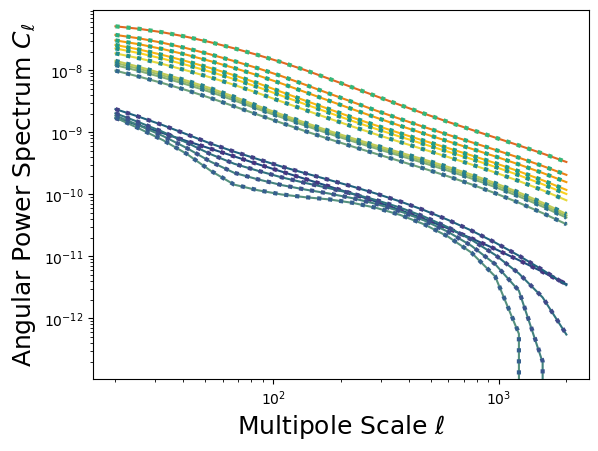

In [3]:
p.compare_two_data_vector_sets_absolute(shear_cls_1, shear_cls_2, ells1, ells2)

# Plot the angular power spectra relative differences
Unlike above, we shold always divide the two spectra to see the relative differences.
We do so by taking every correlation from the probe and dividing it by the corresponding correlation from the reference. We subtract 1 to see the relative difference.

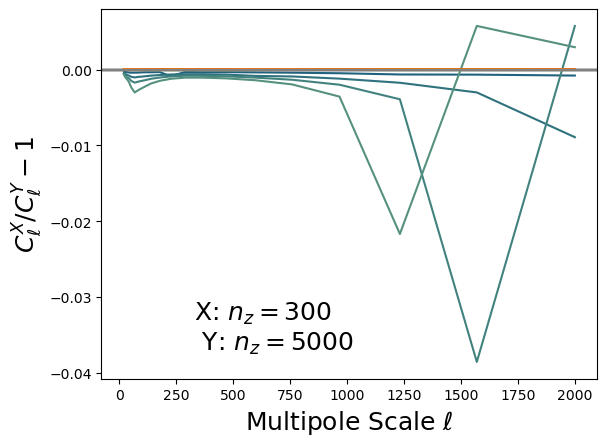

In [22]:
p.compare_two_data_vector_sets_relative(shear_cls_1,
                                        shear_cls_2,
                                        ells1,
                                        label_1=f"$n_z={redshift_resolution_1}$", 
                                        label_2=f"$n_z={redshift_resolution_2}$")

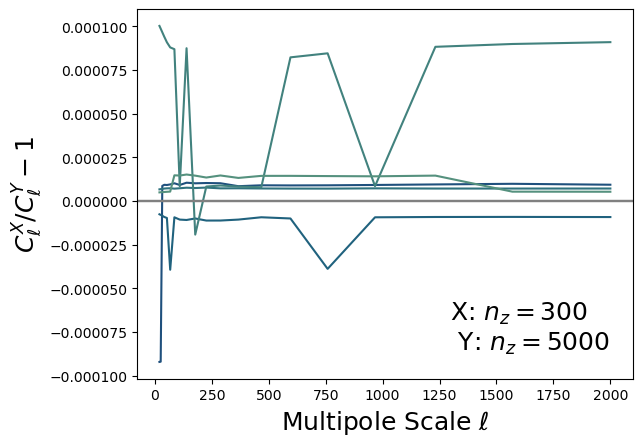

In [23]:
p.compare_two_data_vector_sets_relative(clu_cls_1,
                                        clu_cls_2,
                                        ells1,
                                        label_1=f"$n_z={redshift_resolution_1}$",
                                        label_2=f"$n_z={redshift_resolution_2}$")

# Chi-squared comparison
In order to perform chi-squared tests, we need to compute the spectra with all the correlations included.

In [6]:
shear_cls_all_1 = dv1.cosmic_shear_cls(include_all_correlations=True)
shear_cls_all_2 = dv2.cosmic_shear_cls(include_all_correlations=True)

clu_cls_all_1 = dv1.galaxy_clustering_cls(include_all_correlations=True)
clu_cls_all_2 = dv2.galaxy_clustering_cls(include_all_correlations=True)

ggl_cls_all_1 = dv1.galaxy_galaxy_lensing_cls(include_all_correlations=True)
ggl_cls_all_2 = dv2.galaxy_galaxy_lensing_cls(include_all_correlations=True)

Data saved to data_output/angular_power_spectra/cosmic_shear_correlations_all_y1.npy
Data saved to data_output/angular_power_spectra/cosmic_shear_cls_all_y1_zmax3.5_zres300_ccl_v2.8.0.npy
Data saved to data_output/angular_power_spectra/cosmic_shear_correlations_all_y1.npy
Data saved to data_output/angular_power_spectra/cosmic_shear_cls_all_y1_zmax3.5_zres5000_ccl_v2.8.0.npy
Data saved to data_output/angular_power_spectra/galaxy_clustering_correlations_all_y1.npy
Data saved to data_output/angular_power_spectra/galaxy_clustering_cls_all_y1_zmax3.5_zres300_ccl_v2.8.0.npy
Data saved to data_output/angular_power_spectra/galaxy_clustering_correlations_all_y1.npy
Data saved to data_output/angular_power_spectra/galaxy_clustering_cls_all_y1_zmax3.5_zres5000_ccl_v2.8.0.npy
Data saved to data_output/angular_power_spectra/galaxy_galaxy_lensing_correlations_all_y1.npy
Data saved to data_output/angular_power_spectra/galaxy_galaxy_lensing_cls_all_y1_zmax3.5_zres300_ccl_v2.8.0.npy
Data saved to data_o

In [21]:
# Initialize DataVectorMetrics for both redshift resolutions
dvm1 = DataVectorMetrics(presets1)
dvm2 = DataVectorMetrics(presets2)

# Compute chi-squared differences using both methods
# Do not worry if yo uinitialize the class with either of the redshift resolutions
# since the class will automatically adjust to both resolutions
delta_chi2 = dvm1.get_delta_chi2(cls_gc=clu_cls_all_1,
                                 cls_ggl=ggl_cls_all_1,
                                 cls_cs=shear_cls_all_1,
                                 cls_gc_ref=clu_cls_all_2,
                                 cls_ggl_ref=ggl_cls_all_2, 
                                 cls_cs_ref=shear_cls_all_2)

# Display the message with LaTeX math formatting in scientific notation
display(Markdown(
    f"**Delta Chi-squared test** for spectra computed with $z_\\mathrm{{res}}$: {redshift_resolution_1} and $z_\\mathrm{{res}}$: {redshift_resolution_2} \n\n"
    f"Resulting value of $\\Delta \\chi^2 = {delta_chi2:.2e}$"
))


**Delta Chi-squared test** for spectra computed with $z_\mathrm{res}$: 300 and $z_\mathrm{res}$: 5000 

Resulting value of $\Delta \chi^2 = 2.40e-06$